### Klasy bazowe

In [1]:
import abc

import tensorflow as tf

class AbstractLayer(tf.keras.layers.Layer):
    """Abstract Layer."""
    
    def __init__(self):
        """Inits the class."""
        super(AbstractLayer, self).__init__()
    
    @abc.abstractmethod
    def call(self, inputs):
        """Makes forward pass of the layer."""
        pass


class AbstractModel(tf.keras.Model):
    """Abstract model."""

    def __init__(self):
        """Inits the class."""
        super(AbstractModel, self).__init__()

    @abc.abstractmethod
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        pass

    @abc.abstractmethod
    def fit(self, **kwargs):
        """Fits the model.

        Replaces original fit method.
        
        More information can be found in documentation:
        https://www.tensorflow.org/guide/eager
        https://www.tensorflow.org/guide/autodiff
        """
        pass

    @abc.abstractmethod
    def predict(self, x):
        """Predicts x"""
        pass


### Instrukcje pomoniczne do wykonania przetwarzania wstępnego


In [2]:
import pickle

# Wczytanie zbioru danych
dataset_path = 'dataset.pkl'

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)  
images_raw_train = dataset['train']['X']
images_raw_test = dataset['test']['X']
images_raw_valid = dataset['validation']['X']

labels = dataset['train']['y']
labels_test = dataset['test']['y']
lebels_valid = dataset['validation']['y']

# Ustawienie ziarna
tf.random.set_seed(1234)

# Zmiana rozmiaru obrazu z 224x224 do 64x64
images = tf.image.resize(
    images_raw_train, [64, 64], 
    method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, 
    preserve_aspect_ratio=False,
    name=None
)

images_test = tf.image.resize(
    images_raw_test, [64, 64], 
    method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, 
    preserve_aspect_ratio=False,
    name=None
)

images_valid = tf.image.resize(
    images_raw_valid, [64, 64], 
    method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, 
    preserve_aspect_ratio=False,
    name=None
)

# Zmiana typu obrazów z int na float i normalizacja wartości pikseli z przedziału 0-255 do przedziału 0-1
images = tf.cast(images, tf.float32) / 255.0
images_test = tf.cast(images_test, tf.float32) / 255.0
images_valid = tf.cast(images_valid, tf.float32) / 255.0
    
# Zmiana wymiarowości z [8870] na [8870, 1] w celu zastosowania `SparseCategoricalCrossentropy`
labels = tf.reshape(labels, [-1, 1])
labels_test = tf.reshape(labels_test, [-1, 1])
labels_valid = tf.reshape(lebels_valid, [-1, 1])
# Do iterowania zbioru danych i podzielenia na paczki (ang. batch) można wykorzystać interfejs zdefiniowany w `tensorflow.data.Dataset`



Prezentacja danych:

<Figure size 432x288 with 0 Axes>

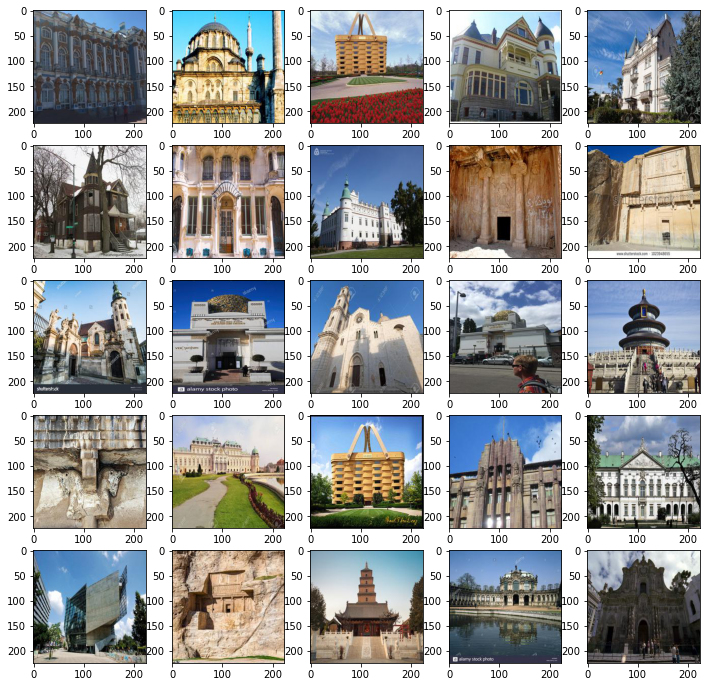

In [3]:
import matplotlib.pyplot as plt
plt.figure()
plt.figure(figsize=(12,12))
rows = 5
cols = 5
for img in range(rows*cols):
    plt.subplot(rows,cols,img+1)
    plt.imshow(dataset['train']['X'][img])
plt.show()

In [4]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

###  Implementacja modelu MLP

In [5]:
from tqdm import tqdm


In [6]:
import abc
import tensorflow as tf

class MLP_Layer(AbstractLayer):
    
    def __init__(self, units,initilizer_weights,initilizer_bias):
        """Inits the class."""
        self.units = units
        self.weights_initilizer=initilizer_weights
        self.bias_initilizer=initilizer_bias
        super(MLP_Layer, self).__init__()
    
    def build(self, input_shape):
        """Here we build our layer. Here will be create Weights and baiases"""
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer=self.weights_initilizer,
                                      trainable=True)
        
        self.b = self.add_weight(shape=(self.units,),initializer=self.bias_initilizer,trainable=True)
    def call(self, inputs):
        """Makes forward pass of the layer."""
        #y = a*x +b  -> weights * input + bias
        ax = tf.matmul(inputs, self.w)
        y = ax + self.b
        return y    

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
class MLP(AbstractModel):
    
    def __init__(self,from_logits=False):
        super(MLP, self).__init__()
        self.lr = 1e-3
        self.optim = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits) #from logits zamiast softmaxa można
        self.batch_size = 100
        self.num_epochs = 25
    def compile(self, **kwargs):
        number_of_MLP_layers = kwargs['layers']
        units = kwargs['units']
        weig_init = kwargs['initializer_weights']
        bias_init = kwargs['initializer_bias']
        self.MPL_layers =[]
        for layer in range(number_of_MLP_layers):
            self.MPL_layers.append(MLP_Layer(units=units,initilizer_weights=weig_init,initilizer_bias=bias_init))
        self.full_connected_2 = MLP_Layer(units=14,initilizer_weights=weig_init,initilizer_bias=bias_init)
        if 'optim' in kwargs:
            self.optim = kwargs['optim']
        if 'batch' in kwargs:
            self.batch_size = kwargs['batch'] 
        if 'epoch' in kwargs:
            self.num_epoch = kwargs['epoch'] 
            
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        x = tf.reshape(inputs,[inputs.shape[0],64*64*3])
        for layer in self.MPL_layers:
            x= layer(x)
            x=tf.nn.relu(x)
        x = self.full_connected_2(x)
        x = tf.nn.softmax(x) #Activation 2 layer
        return x

    def fit(self, **kwargs):
        history = {'Loss':[],
                   'Accuracy':[],
                   'Fscore':[]}
        history_test = {'Loss':[],
                   'Accuracy':[],
                   'Fscore':[]}
        history_valid = {'Loss':[],
                    'Accuracy':[],
                   'Fscore':[]}
        
        batch_size = self.batch_size
        #print(type(history['loss']))
        train_dataset= kwargs['dataset']
        train_labels = kwargs['labels_train']
        test_dataset= kwargs['dataset_test']
        valid_dataset= kwargs['dataset_valid']
        labels_valid= kwargs['labels_valid']
        labels_test=kwargs['labels_test']
        batch = kwargs['batch']
        self.num_epochs = kwargs['epochs']
        NUMBER_OF_CLASSES = 14
        train_ds = tf.data.Dataset.from_tensor_slices((images, labels)) 
        size=len(train_dataset)
        train_ds = train_ds.shuffle(buffer_size=size).batch(batch_size=batch)
        size = size/batch_size
        if(train_dataset!=None):
            for epoch in tqdm(range(self.num_epochs)):
                loss_sum = 0
                fscore = 0
                prec = 0
                recall = 0
                acc = 0
                iterator=0
                for x, y in train_ds:
                    iterator+=1
                    with tf.GradientTape() as tape:
                        y_prediction = self.call(x,training=True)
                        loss = self.loss_fn(y_true=y,y_pred=y_prediction)
                        loss_sum+=tf.keras.backend.sum(loss)
                    grads = tape.gradient(loss, self.trainable_variables)
                    self.optim.apply_gradients(zip(grads,self.trainable_variables))     
                history['Loss'].append((loss_sum/iterator).numpy())
                pred = self.predict(train_dataset)
                acc, F = self.validate(y_pred=pred,y_true=train_labels)
                history['Accuracy'].append(acc)
                history['Fscore'].append(F)
                   
            
                y_prediction = self.predict(test_dataset)
                y_loss = self.call(test_dataset).numpy()
                acc, F = self.validate(y_pred=y_prediction,y_true=labels_test)
                loss = self.loss_fn(y_true=labels_test,y_pred=y_loss)
                history_test['Loss'].append(loss.numpy())
                history_test['Accuracy'].append(acc)
                history_test['Fscore'].append(F)
                
                y_prediction = self.predict(valid_dataset)
                y_loss = self.call(valid_dataset).numpy()
                acc = self.validate(y_pred=y_prediction,y_true=labels_valid)
                loss = self.loss_fn(y_true=labels_valid,y_pred=y_loss)
                history_valid['Loss'].append(loss.numpy())
                history_valid['Accuracy'].append(acc)
                history_valid['Fscore'].append(F)
              
                
        else:
            print('provide dataset')
              
        return history, history_test, history_valid
        pass
    def validate(self,y_true,y_pred):
        re = tf.reshape(y_pred,[-1,1]).numpy()
        true = y_true.numpy()
       
        acc = accuracy_score(y_true=true,y_pred=re).sum()
        acc = np.mean(acc)
        F1 = f1_score(y_true=true,y_pred=re,average="macro")
        return acc, F1
    def predict(self, x):
        """Predicts x"""
        pred = self.call(x,training=False)
        return tf.argmax(input=pred, axis=1)
        
        

In [10]:
import pandas as pd
COLUMNS = ['Loss','Accuracy','Fscore','layers','weights','biases','units','optim','lr','batch size','epochs']
history_competition=pd.DataFrame(columns=COLUMNS)
history_competition

Empty DataFrame
Columns: [Loss, Accuracy, Fscore, layers, weights, biases, units, optim, lr, batch size, epochs]
Index: []

In [11]:
def research(layers,units,init_weights,init_bias,batch,optim,epoch):
    
    history_competition=pd.DataFrame(columns=['Loss','Accuracy','Fscore','layers','weights','biases','units','optim','lr'])
    
    model=MLP()
    model.compile(layers=layers,units=units,initializer_weights=init_weights,initializer_bias=init_bias,batch=batch,optim=optim,epoch=epoch)
    
    history, history_test, history_valid = model.fit(dataset=images,labels_train=labels,epochs=epoch,dataset_test=images_test, dataset_valid=images_valid, labels_test=labels_test, labels_valid=labels_valid,batch=batch)
    data = pd.DataFrame(history_test).tail(1).reset_index(drop=True)
    params = pd.DataFrame([[layers,init_weights._tf_api_names,init_bias._tf_api_names,units,model.optim._name,model.optim._hyper['learning_rate'].numpy(),model.batch_size,model.num_epoch]],columns=['layers','weights','biases','units','optim','lr','batch size','epochs'])
    data = pd.concat([data,params],axis=1)
    history_competition=history_competition.append(data)
    return history_competition

***Number of layers***:1-5

***initilizer of weights***: tf.random_uniform_initializer

***initilizer of biases***: tf.random_uniform_initializer

***Units***:256

In [ ]:
history_competition=history_competition.append(research(1,256,tf.random_uniform_initializer,tf.random_uniform_initializer,batch=100))
history_competition=history_competition.append(research(2,256,tf.random_uniform_initializer,tf.random_uniform_initializer,batch=100))
history_competition=history_competition.append(research(5,256,tf.random_uniform_initializer,tf.random_uniform_initializer,batch=100))
history_competition=history_competition.append(research(10,256,tf.random_uniform_initializer,tf.random_uniform_initializer,batch=100))

***Number of layers***:1-5

***initilizer of weights***: tf.random_normal_initializer

***initilizer of biases***: tf.random_uniform_initializer

***Units***:256

In [ ]:
history_competition=history_competition.append(research(1,256,tf.random_normal_initializer,tf.random_uniform_initializer,batch=100))
history_competition=history_competition.append(research(2,256,tf.random_normal_initializer,tf.random_uniform_initializer,batch=100))
history_competition=history_competition.append(research(5,256,tf.random_normal_initializer,tf.random_uniform_initializer,batch=100))
history_competition=history_competition.append(research(10,256,tf.random_normal_initializer,tf.random_uniform_initializer,batch=100))

***Number of layers***:1-5

***initilizer of weights***: tf.random_normal_initializer

***initilizer of biases***: tf.random_normal_initializer

***Units***:256

In [151]:
history_competition=history_competition.append(research(1,256,tf.random_normal_initializer,tf.random_normal_initializer,batch=100))
history_competition=history_competition.append(research(2,256,tf.random_normal_initializer,tf.random_normal_initializer,batch=100))
history_competition=history_competition.append(research(5,256,tf.random_normal_initializer,tf.random_normal_initializer,batch=100))
history_competition=history_competition.append(research(10,256,tf.random_normal_initializer,tf.random_normal_initializer,batch=100))




  0%|                                                                                                                                                                                                                                                                         | 0/25 [00:00<?, ?it/s]


  4%|██████████▎                                                                                                                                                                                                                                                      | 1/25 [00:07<02:48,  7.04s/it]


  8%|████████████████████▌                                                                                                                                                                                                                                            | 2/25 [00:13<02:41,  7.01s/it]


 12%|██████████████████████████████▊                                                                         

  0%|                                                                                                                                                                                                                                                                         | 0/25 [00:00<?, ?it/s]


  4%|██████████▎                                                                                                                                                                                                                                                      | 1/25 [00:09<03:41,  9.22s/it]


  8%|████████████████████▌                                                                                                                                                                                                                                            | 2/25 [00:18<03:31,  9.18s/it]


 12%|██████████████████████████████▊                                                                            

***Number of layers***:1-5

***initilizer of weights***: tf.random_uniform_initializer

***initilizer of biases***: tf.random_normal_initializer

***Units***:256

In [152]:
history_competition=history_competition.append(research(1,256,tf.random_normal_initializer,tf.random_uniform_initializer,batch=100))
history_competition=history_competition.append(research(2,256,tf.random_normal_initializer,tf.random_uniform_initializer,batch=100))
history_competition=history_competition.append(research(5,256,tf.random_normal_initializer,tf.random_uniform_initializer,batch=100))
history_competition=history_competition.append(research(10,256,tf.random_normal_initializer,tf.random_uniform_initializer,batch=100))




  0%|                                                                                                                                                                                                                                                                         | 0/25 [00:00<?, ?it/s]


  4%|██████████▎                                                                                                                                                                                                                                                      | 1/25 [00:08<03:13,  8.08s/it]


  8%|████████████████████▌                                                                                                                                                                                                                                            | 2/25 [00:15<03:02,  7.92s/it]


 12%|██████████████████████████████▊                                                                         

  0%|                                                                                                                                                                                                                                                                         | 0/25 [00:00<?, ?it/s]


  4%|██████████▎                                                                                                                                                                                                                                                      | 1/25 [00:09<03:39,  9.16s/it]


  8%|████████████████████▌                                                                                                                                                                                                                                            | 2/25 [00:18<03:31,  9.19s/it]


 12%|██████████████████████████████▊                                                                            

In [24]:
history_competition.to_csv("MLP_PARAMS_1.csv",index=False)

In [1]:
import pandas as pd
history_competition=pd.read_csv("MLP_PARAMS_1.csv")

In [2]:
history_competition.sort_values(by=['Fscore'],ascending=False)

Loss  Accuracy    Fscore  layers                          weights  \
9   2.493940  0.258935  0.247341       2   ('random_normal_initializer',)   
5   2.441079  0.248820  0.244889       2   ('random_normal_initializer',)   
13  2.427198  0.252529  0.237064       2   ('random_normal_initializer',)   
1   2.447052  0.269049  0.233423       2  ('random_uniform_initializer',)   
6   2.504672  0.256575  0.224740       5   ('random_normal_initializer',)   
4   2.449885  0.222522  0.209362       1   ('random_normal_initializer',)   
0   2.449420  0.244100  0.201127       1  ('random_uniform_initializer',)   
14  2.442891  0.241065  0.195643       5   ('random_normal_initializer',)   
2   2.475966  0.248820  0.194454       5  ('random_uniform_initializer',)   
10  2.495870  0.236008  0.192777       5   ('random_normal_initializer',)   
12  2.476855  0.212070  0.172576       1   ('random_normal_initializer',)   
8   2.385365  0.226568  0.152916       1   ('random_normal_initializer',)   
7   2.418595  0.237357  0.138650      10   ('random_normal_initializer',)   
15  2.465148  0.214767  0.109016      10   ('random_normal_initializer',)   
11  2.442924  0.212070  0.096342      10   ('random_normal_initializer',)   
3   2.476034  0.178355  0.038114      10  ('random_uniform_initializer',)   

                             biases  units  
9    ('random_normal_initializer',)    256  
5   ('random_uniform_initializer',)    256  
13  ('random_uniform_initializer',)    256  
1   ('random_uniform_initializer',)    256  
6   ('random_uniform_initializer',)    256  
4   ('random_uniform_initializer',)    256  
0   ('random_uniform_initializer',)    256  
14  ('random_uniform_initializer',)    256  
2   ('random_uniform_initializer',)    256  
10   ('random_normal_initializer',)    256  
12  ('random_uniform_initializer',)    256  
8    ('random_normal_initializer',)    256  
7   ('random_uniform_initializer',)    256  
15  ('random_uniform_initializer',)    256  
11   ('random_normal_initializer',)    256  
3   ('random_uniform_initializer',)    256

###### Najlepszym modelem okazał się model o dwóch warstwach i wagami i biasami z rozkładu normalnego.

#### Teraz należy sprawdzić :
##### - Liczbę epok uczenia
##### - Metody optymalizacji modelu
##### -Różne liczności paczek (mini batch)
##### -Różne wartości współczynnika uczenia

#### Metody optymalizacji modelu
## Adam , SGD, NAdam 
Docelowymi parametrami modelu jest najlepszy model z podpunktu wyżej

In [21]:
history_competition=pd.DataFrame(columns=COLUMNS)
history_competition

Empty DataFrame
Columns: [Loss, Accuracy, Fscore, layers, weights, biases, units, optim, lr, batch size, epochs]
Index: []

In [22]:
EPOCH = [25,50,100]
BATCHES  = [ 100, 200, 400]
LR = [0.001,0.01,0.005]
for epoch in EPOCH:
    for batch in BATCHES:
        for lr in LR:    
            print('NEW LOOP')
            history_competition=history_competition.append(research(2,256,tf.random_normal_initializer,tf.random_normal_initializer,batch=batch,optim=tf.keras.optimizers.Nadam(learning_rate=lr),epoch=epoch))
            print('NADAM',epoch,batch,lr,'DONE')
            history_competition=history_competition.append(research(2,256,tf.random_normal_initializer,tf.random_normal_initializer,batch=batch,optim=tf.keras.optimizers.Adam(learning_rate=lr),epoch=epoch))
            print('ADAM',epoch,batch,lr,'DONE')
            history_competition=history_competition.append(research(2,256,tf.random_normal_initializer,tf.random_normal_initializer,batch=batch,optim=tf.keras.optimizers.SGD(learning_rate=lr),epoch=epoch))
            print('SGD',epoch,batch,lr,'DONE')
            history_competition.to_csv("MLP_PARAMS_2.csv",index=False)


NEW LOOP


NameError: name 'research' is not defined

In [24]:
import pandas as pd
history_competition=pd.read_csv("MLP_PARAMS_2.csv")
pd.options.display.max_rows = 4000
history_competition.sort_values(by=['Fscore'],ascending=False)

Loss  Accuracy    Fscore  layers                         weights  \
64   5.358891  0.284558  0.275329       2  ('random_normal_initializer',)   
28   3.488418  0.268038  0.272130       2  ('random_normal_initializer',)   
27   3.187775  0.265678  0.255621       2  ('random_normal_initializer',)   
37   3.053844  0.240728  0.246001       2  ('random_normal_initializer',)   
73   3.898921  0.250506  0.245556       2  ('random_normal_initializer',)   
54   4.343975  0.256237  0.244087       2  ('random_normal_initializer',)   
55   6.385560  0.257249  0.242011       2  ('random_normal_initializer',)   
62   2.407799  0.255226  0.240534       2  ('random_normal_initializer',)   
32   2.344236  0.242751  0.239133       2  ('random_normal_initializer',)   
46   2.638489  0.238705  0.235545       2  ('random_normal_initializer',)   
59   3.013742  0.274444  0.224760       2  ('random_normal_initializer',)   
10   2.429786  0.238031  0.221636       2  ('random_normal_initializer',)   
0    2.444752  0.238031  0.221121       2  ('random_normal_initializer',)   
68   2.471185  0.261295  0.217037       2  ('random_normal_initializer',)   
1    2.563978  0.247134  0.209686       2  ('random_normal_initializer',)   
72   2.838919  0.236345  0.202449       2  ('random_normal_initializer',)   
35   2.299524  0.256575  0.199594       2  ('random_normal_initializer',)   
71   2.336547  0.249494  0.199266       2  ('random_normal_initializer',)   
77   2.366196  0.232974  0.197617       2  ('random_normal_initializer',)   
41   2.291410  0.257586  0.196105       2  ('random_normal_initializer',)   
36   2.994898  0.235671  0.193166       2  ('random_normal_initializer',)   
63   4.851068  0.182063  0.190086       2  ('random_normal_initializer',)   
19   2.418963  0.230276  0.189865       2  ('random_normal_initializer',)   
5    2.322507  0.239042  0.187623       2  ('random_normal_initializer',)   
56   2.333293  0.241065  0.186397       2  ('random_normal_initializer',)   
80   2.337733  0.223871  0.184408       2  ('random_normal_initializer',)   
8    2.325088  0.240391  0.180724       2  ('random_normal_initializer',)   
45   2.580216  0.217465  0.177267       2  ('random_normal_initializer',)   
44   2.334978  0.238705  0.174018       2  ('random_normal_initializer',)   
50   2.328487  0.242077  0.165335       2  ('random_normal_initializer',)   
17   2.360751  0.229939  0.162259       2  ('random_normal_initializer',)   
14   2.338974  0.241065  0.150125       2  ('random_normal_initializer',)   
29   2.361950  0.230276  0.145663       2  ('random_normal_initializer',)   
65   2.363729  0.232637  0.145073       2  ('random_normal_initializer',)   
9    2.743599  0.200270  0.136354       2  ('random_normal_initializer',)   
38   2.409412  0.213756  0.127948       2  ('random_normal_initializer',)   
53   2.365099  0.218139  0.124627       2  ('random_normal_initializer',)   
74   2.412102  0.212070  0.123800       2  ('random_normal_initializer',)   
18   2.615246  0.161834  0.119176       2  ('random_normal_initializer',)   
26   2.428405  0.213082  0.109760       2  ('random_normal_initializer',)   
2    2.430303  0.196561  0.106637       2  ('random_normal_initializer',)   
47   2.467147  0.187121  0.100612       2  ('random_normal_initializer',)   
23   2.501509  0.160486  0.094135       2  ('random_normal_initializer',)   
11   2.464169  0.191841  0.089822       2  ('random_normal_initializer',)   
20   2.503372  0.178692  0.061598       2  ('random_normal_initializer',)   
39  13.411815  0.167903  0.020538       2  ('random_normal_initializer',)   
4   13.411815  0.167903  0.020538       2  ('random_normal_initializer',)   
7   13.411815  0.167903  0.020538       2  ('random_normal_initializer',)   
67  13.411815  0.167903  0.020538       2  ('random_normal_initializer',)   
66  13.411815  0.167903  0.020538       2  ('random_normal_initializer',)   
30  13.411815  0.167903  0.020538       2  ('random_normal_initializer',)   
31  1

In [12]:
model=MLP()
model.compile(layers=2,
              units=256,
              initializer_weights=tf.random_normal_initializer,
              initializer_bias=tf.random_normal_initializer,
              batch=200,
              optim=tf.keras.optimizers.Nadam(learning_rate=0.001),
              epoch=100)


In [13]:
history, history_test, history_valid = model.fit(dataset=images,labels_train=labels,epochs=100,dataset_test=images_test, dataset_valid=images_valid, labels_test=labels_test, labels_valid=labels_valid,batch=200)   

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


In [14]:
history = pd.DataFrame(history)
tmp = pd.DataFrame(history_test).add_prefix('test_')
tmp2= pd.DataFrame(history_valid).add_prefix('valid_')
results= pd.concat([tmp,tmp2],axis=1)
results= pd.concat([results,history],axis=1)

In [15]:
results

test_Loss  test_Accuracy  test_Fscore  valid_Loss  \
0    2.529044       0.184086     0.049964    2.539129   
1    2.452564       0.189144     0.082559    2.466750   
2    2.554003       0.139919     0.077272    2.548983   
3    2.470727       0.153068     0.077490    2.478563   
4    2.413075       0.202630     0.134983    2.414292   
..        ...            ...          ...         ...   
95   3.736643       0.284221     0.273678    3.750029   
96   3.550263       0.287930     0.289019    3.557676   
97   3.746957       0.263655     0.277353    3.713209   
98   4.827035       0.207013     0.197829    4.793872   
99   3.920703       0.268038     0.271475    3.894989   

                                valid_Accuracy  valid_Fscore      Loss  \
0   (0.17813765182186234, 0.04595097475109721)      0.049964  2.709586   
1   (0.18454790823211875, 0.07901322097794042)      0.082559  2.469884   
2    (0.1420377867746289, 0.07839456436480872)      0.077272  2.429084   
3   (0.15215924426450742, 0.07877101879072228)      0.077490  2.408594   
4     (0.19736842105263158, 0.128752282836218)      0.134983  2.374476   
..                                         ...           ...       ...   
95    (0.2813765182186235, 0.2650870245011679)      0.273678  0.526277   
96   (0.2894736842105263, 0.28299646343842333)      0.289019  0.610835   
97   (0.2624831309041835, 0.27294248525187503)      0.277353  0.660819   
98  (0.21322537112010798, 0.20244046627756077)      0.197829  0.472199   
99  (0.25775978407557354, 0.25549422980333764)      0.271475  0.654283   

    Accuracy    Fscore  
0   0.178692  0.044646  
1   0.197520  0.094576  
2   0.151747  0.083289  
3   0.166742  0.092759  
4   0.219729  0.150188  
..       ...       ...  
95  0.807103  0.806679  
96  0.870462  0.869356  
97  0.785457  0.792717  
98  0.559865  0.542621  
99  0.769448  0.781398  

[100 rows x 9 columns]

Text(0, 0.5, 'Value')

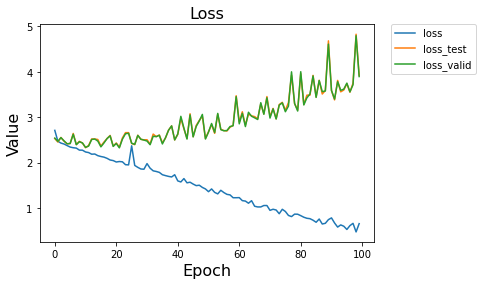

In [19]:
plt.plot(history['Loss'], label="loss")
plt.plot(history_test['Loss'], label="loss_test")
plt.plot(history_valid['Loss'], label="loss_valid")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Value', fontsize=16)

[]

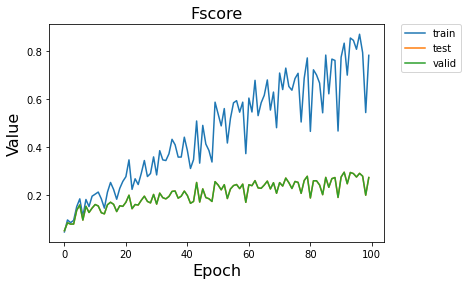

In [20]:
fig1, ax1 = plt.subplots()
ax1.plot(history['Fscore'], label="train")
ax1.plot(history_test['Fscore'],label="test")
ax1.plot(history_valid['Fscore'],label="valid")
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Fscore', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Value', fontsize=16)
ax1.plot()

[]

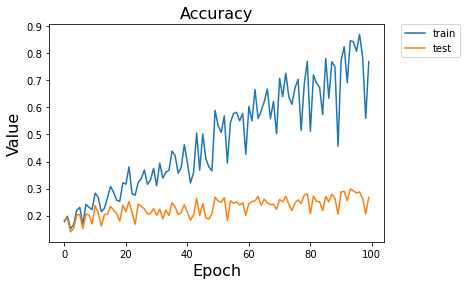

In [21]:
fig1, ax1 = plt.subplots()
ax1.plot(history['Accuracy'], label="train")
ax1.plot(history_test['Accuracy'],label="test")
#ax1.plot(history_valid['Accuracy'],label="valid")
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Value', fontsize=16)
ax1.plot()

In [22]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


Confusion matrix, without normalization


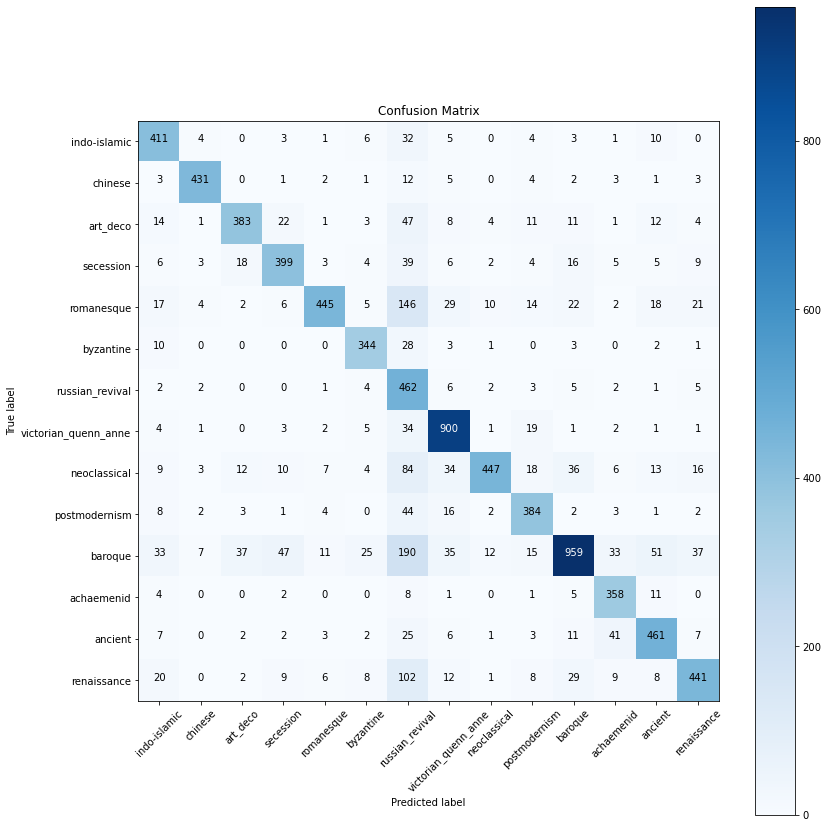

In [23]:
cm_plot_labels = list(dataset['labels_mapping'].keys())
X = model.predict(images)
cm = confusion_matrix(y_true=labels, y_pred=X)
from pylab import rcParams
rcParams['figure.figsize'] = 12, 12
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

### Podsumowanie uczenia modelu
##### Najlepszym modelem okazałą się dwu warstwowa sieć neuronowa z rozkładem normalnym (0,0.5), krokiem w uczeniu 0.001, sto epok uczenia i optymalizatorem ADAM.

1. Ilość warstw : Warstwy na których testowałem tą sieć MLP to 1/2/5. Niemal wszystkie sieci o dwóch warstwach były lepsze od pojedyńczej warstwy lub pięciu. W przypadku pierwszej warstwy zdecydowanie sieć była zbyt mało skomplikowana aby wyuczyć się aż 14 klas, w przypadku pięciu warstw jest duża szansa że wyuczyła się pojedyńczysz przykładów na pamięć.

2. Wagi i biasy: Najlepszym wyobrem okazał się inicjalizator z rozkładu normalnego o średniej 0 i odchyleniu 0.05. Posiada więc jednocześnie liczby ujemne i dodatnie bliskie 0. W przeciwieństwie do drugiego inicjatora uniform który nie posiadał ujemnych wag a jedynie z przedziału [0,1) . Więc wagi początkowe ostylowały wokół zera, a w uniformowych mogły być zdecydowanie dużo dużo większe.

3. Learning-rate: Dobrym krokiem uczenia okazał się 0.001, widocznie większy krok (0.05 i 0.01) nie były wstanie dobrze nakierować na minimum.

4. Optymalizator Adam - Optymalizacja Adam jest wariantem SGD, w którym utrzymujemy wskaźnik uczenia na parametr (wagę) i aktualizujemy go na podstawie średniej i wariancji poprzednich gradientów
tego parametru. - "TensorFlow Machine Learning Projects: Build 13 real-world projects with advanced
numerical computations using the Python ecosystem"
Przetesowano i SGD, NAdama i Adama gdzie optymalizator Adam wyszedł zwycięsko. Jak z cytatu powyżej widać jest ulepszoną wersji SGD. Jednakże podczas testów wynikło że najgorsze i najlepsze modele korzystały właśnie z Adama. Modele uczone klasycznym SGD zajmowały średnie pozycje. 

5


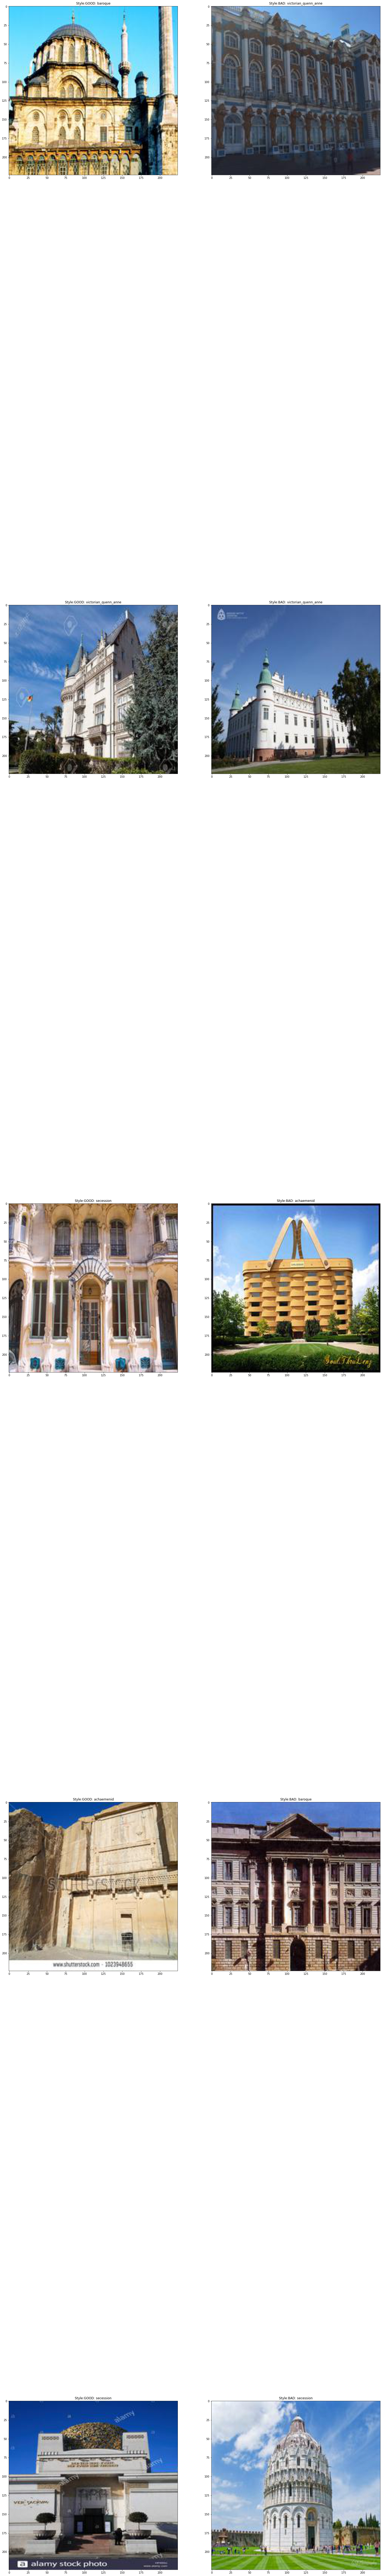

In [64]:
good_img = []
bad_img = []
for i, prediction in enumerate(X):
    if labels[i] == prediction:
        good_img.append(i)
    else:
        bad_img.append(i)

from pylab import rcParams
rcParams['figure.figsize'] = 10, 15
fig = plt.figure(figsize=(25,200))
columns = 2
print(rows)
ax = []
for i in range(rows*columns):
    style=""
    img_to_show = None
    ax.append( fig.add_subplot(rows, columns, i+1) )
    if i%2 == 0:
        img_to_show=dataset['train']['X'][good_img[i]]
        img_key = (labels[good_img[i]]).numpy()[0]
        style='GOOD: '+ cm_plot_labels[img_key]
        
    else:   
        img_to_show=dataset['train']['X'][bad_img[i-1]]
        img_key = (labels[good_img[i]]).numpy()[0]
        style='BAD: '+cm_plot_labels[img_key]
    ax[-1].set_title("Style:"+style)  # set title
    plt.imshow(img_to_show)